In [18]:
# Core
import json
from pathlib import Path

# Plotting
import matplotlib.pyplot as plt

# Neuroimaging
import nibabel as nib
import numpy as np

# Data handling
import pandas as pd


In [19]:
def find_t1w_images(bids_root):
    bids_root = Path(bids_root)
    t1w_files = list(bids_root.rglob("*T1*.nii*"))
    return sorted(t1w_files)


def load_json_sidecar(nifti_path):
    json_path = nifti_path.with_suffix("").with_suffix(".json")
    if json_path.exists():
        with open(json_path, "r") as f:
            return json.load(f)
    return {}


def extract_t1w_stats(nifti_path):
    try:
        img = nib.load(str(nifti_path))
    except Exception as e:
        return {"path": str(nifti_path), "error": str(e)}
    header = img.header
    sidecar = load_json_sidecar(nifti_path)

    # Dimensions
    dims = img.shape
    voxel_sizes = header.get_zooms()[:3]

    # File size (MB)
    file_size_mb = nifti_path.stat().st_size / (1024**2)

    stats = {
        "subject": nifti_path.name.split("_")[0],
        "session": next((p for p in nifti_path.parts if p.startswith("ses-")), None),
        "path": str(nifti_path),
        "dim_x": dims[0],
        "dim_y": dims[1],
        "dim_z": dims[2],
        "voxel_x_mm": voxel_sizes[0],
        "voxel_y_mm": voxel_sizes[1],
        "voxel_z_mm": voxel_sizes[2],
        "file_size_mb": file_size_mb,
        # Metadata (JSON sidecar)
        "tesla": sidecar.get("MagneticFieldStrength"),
        "manufacturer": sidecar.get("Manufacturer"),
        "model": sidecar.get("ManufacturersModelName"),
        "TR": sidecar.get("RepetitionTime"),
        "TE": sidecar.get("EchoTime"),
        "flip_angle": sidecar.get("FlipAngle"),
    }

    return stats


def plot_histogram(df, key, bins=20, dropna=True, eps=1e-8):
    if key not in df.columns:
        raise ValueError(f"Key '{key}' not found in dataframe")

    data = df[key]

    if dropna:
        data = data.dropna()

    if len(data) == 0:
        print(f"[WARN] No data available for '{key}'")
        return

    # Attempt numeric conversion
    is_numeric = True
    try:
        data = pd.to_numeric(data)
    except (ValueError, TypeError):
        is_numeric = False

    plt.figure()

    if is_numeric:
        data_min = data.min()
        data_max = data.max()

        # Zero or near-zero range → constant value
        if np.isclose(data_min, data_max, atol=eps):
            plt.bar([str(round(float(data_min), 4))], [len(data)])
            plt.xlabel(key)
            plt.ylabel("Count")
            plt.title(f"{key} (constant value)")
        else:
            # Safe bin count
            effective_bins = min(bins, len(data))
            plt.hist(data, bins=effective_bins)
            plt.xlabel(key)
            plt.ylabel("Count")
            plt.title(f"Histogram of {key}")
    else:
        # Categorical fallback
        counts = data.value_counts()
        plt.bar(counts.index.astype(str), counts.values)
        plt.xlabel(key)
        plt.ylabel("Count")
        plt.title(f"Distribution of {key}")
        plt.xticks(rotation=45, ha="right")

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [ ]:
bids_path = "/run/media/falconnier/Elements/datasets/BIDS_datasets/Transdiagnostic_Connectome_Project"  # <-- CHANGE THIS
# bids_path = "/run/media/falconnier/Elements/datasets/BIDS_datasets"  # <-- CHANGE THIS

t1w_files = find_t1w_images(bids_path)
print(f"Found {len(t1w_files)} T1w images")

records = []
for t1w in t1w_files:
    records.append(extract_t1w_stats(t1w))

df = pd.DataFrame(records)
df.head()


Found 243 T1w images


,subject,session,path,dim_x,dim_y,dim_z,voxel_x_mm,voxel_y_mm,voxel_z_mm,file_size_mb,tesla,manufacturer,model,TR,TE,flip_angle
0,sub-NDARINVAG023WG3,None,/run/media/falconnier/Elements/datasets/BIDS_d...,144,192,192,1.2,1.197917,1.197917,5.776229,3,Siemens,Prisma,2.2,0.00157,7
1,sub-NDARINVAG339WHH,None,/run/media/falconnier/Elements/datasets/BIDS_d...,144,192,192,1.2,1.197917,1.197917,5.076036,3,Siemens,Prisma,2.2,0.00157,7
2,sub-NDARINVAG388HJL,None,/run/media/falconnier/Elements/datasets/BIDS_d...,144,192,192,1.2,1.197917,1.197917,5.486135,3,Siemens,Prisma,2.2,0.00157,7
3,sub-NDARINVAG900RVD,None,/run/media/falconnier/Elements/datasets/BIDS_d...,144,192,192,1.2,1.197917,1.197917,5.515716,3,Siemens,Prisma,2.2,0.00157,7
4,sub-NDARINVAH529JMM,None,/run/media/falconnier/Elements/datasets/BIDS_d...,144,192,192,1.2,1.197917,1.197917,5.102840,3,Siemens,Prisma,2.2,0.00157,7


In [21]:
summary = {
    "n_subjects": df["subject"].nunique(),
    "n_sessions": df["session"].nunique(),
    "n_t1w": len(df),
    "voxel_sizes_mm": df[["voxel_x_mm", "voxel_y_mm", "voxel_z_mm"]].drop_duplicates(),
    "tesla_values": df["tesla"].value_counts(dropna=False),
    "manufacturers": df["manufacturer"].value_counts(dropna=False),
}

summary


{'n_subjects': 241,
 'n_sessions': 0,
 'n_t1w': 243,
 'voxel_sizes_mm':      voxel_x_mm  voxel_y_mm  voxel_z_mm
 0      1.200000    1.197917    1.197917
 61     1.199999    1.197917    1.197917
 90     1.200000    1.192708    1.192708
 141    1.200003    1.197917    1.197917,
 'tesla_values': tesla
 3    243
 Name: count, dtype: int64,
 'manufacturers': manufacturer
 Siemens    243
 Name: count, dtype: int64}

In [22]:
df[["voxel_x_mm", "voxel_y_mm", "voxel_z_mm"]].describe()

,voxel_x_mm,voxel_y_mm,voxel_z_mm
count,2.430000e+02,243.000000,243.000000
mean,1.200000e+00,1.197895,1.197895
std,1.672013e-07,0.000334,0.000334
min,1.199999e+00,1.192708,1.192708
25%,1.200000e+00,1.197917,1.197917
50%,1.200000e+00,1.197917,1.197917
75%,1.200000e+00,1.197917,1.197917
max,1.200003e+00,1.197917,1.197917


In [23]:
# Detect mixed resolutions
df.groupby(["voxel_x_mm", "voxel_y_mm", "voxel_z_mm"]).size()


voxel_x_mm  voxel_y_mm  voxel_z_mm
1.199999    1.197917    1.197917        1
1.200000    1.192708    1.192708        1
            1.197917    1.197917      240
1.200003    1.197917    1.197917        1
dtype: int64

In [24]:
# Detect scanner heterogeneity
df.groupby(["manufacturer", "model", "tesla"]).size()


manufacturer  model   tesla
Siemens       Prisma  3        243
dtype: int64

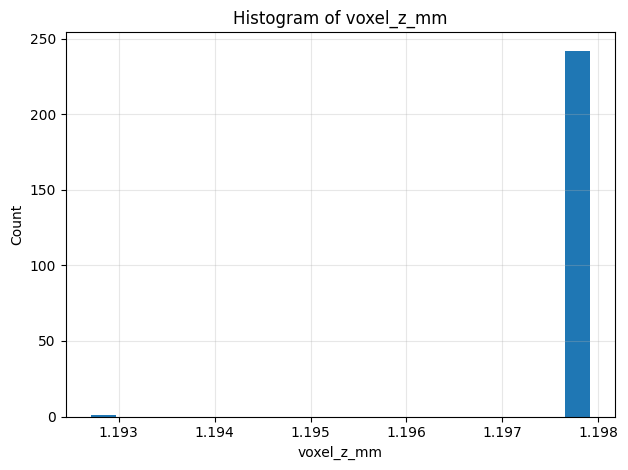

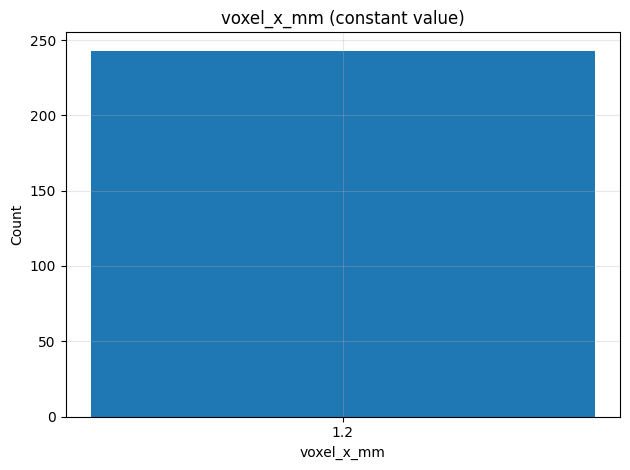

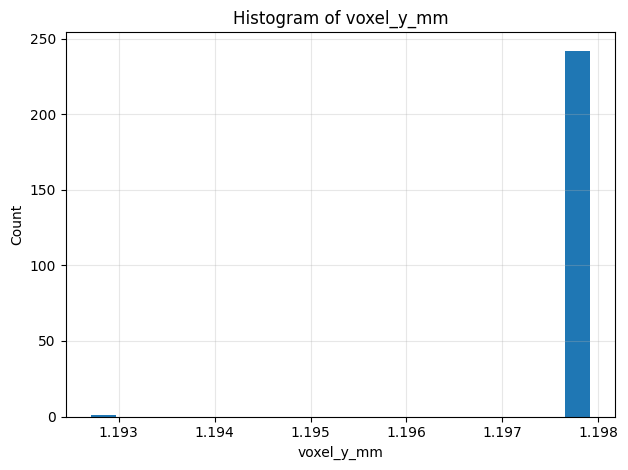

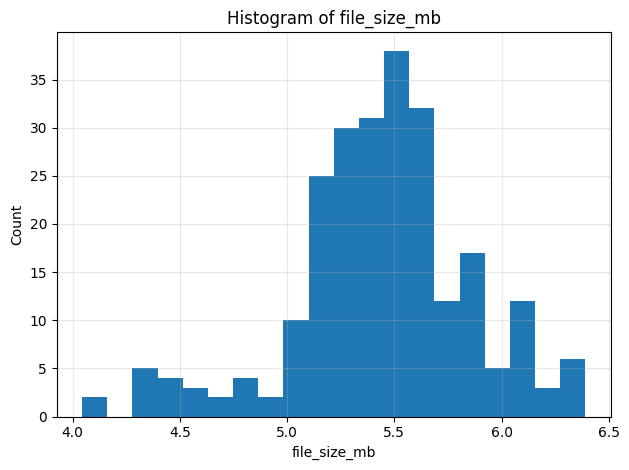

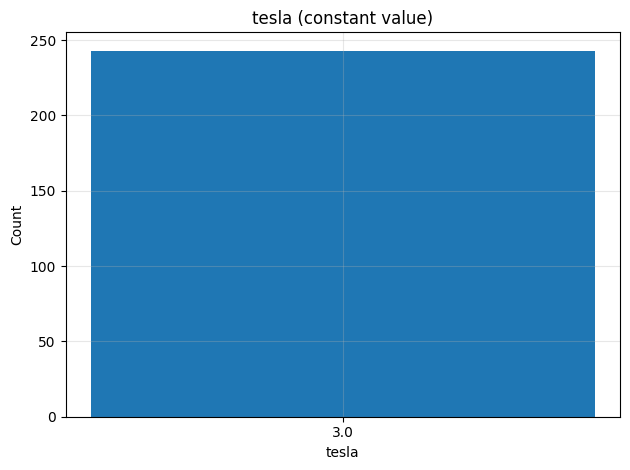

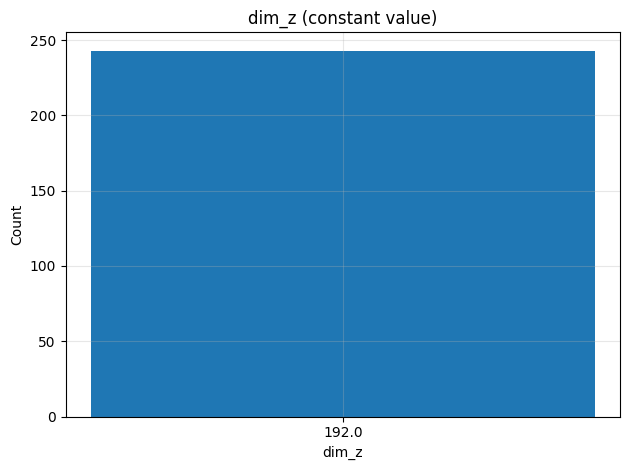

In [25]:
plot_histogram(df, "voxel_z_mm")
plot_histogram(df, "voxel_x_mm")
plot_histogram(df, "voxel_y_mm")
plot_histogram(df, "file_size_mb")
plot_histogram(df, "tesla", bins=5)
plot_histogram(df, "dim_z")
